## Projeto 1 – Backtest Hello World


1.Usando o mesmo grupo dos APS’s

2.Escolha um universo de ativos (>5) em um período t de 

3.Construa uma estratégia de tendência “simples” ou reversão à média (como, mas não pode ser exatamente, um
cruzamento de SMA)

4.Construa a lógica de alocação e backtesting da 

5.Realize testes de sensibilidade no tempo e dos parâmetros

6.Desenvolva uma versão mais “complexa” dessa estratégia

7.Construa a lógica de alocação e backtesting dessa versão mais complexa

8.Realize testes de sensibilidade no tempo e dos parâmetros

9.Apresente em sala os resultados da estratégia (os resultados NÃO precisam ser positivos!!! O importante é tentar)

1.Esta apresentação em sala não requer um ppt, apenas uma passagem pelo código, e uma demonstração dos
resultados. (Em tese a organização do código junto dos resultados deve ser suficiente para o acompanhamento da
estratégia)
10.Durante a apresentação é esperada uma participação de todos os alunos em sala, trazendo dúvidas, questionamentos e
sugestões

### Importações

In [1]:
import pandas as pd
import numpy as np
import json
import os
from datetime import datetime, timedelta
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from tqdm import tqdm
import warnings
import pandas as pd
import numpy as np
from datetime import timedelta
from plotly.subplots import make_subplots
import plotly.graph_objects as go
warnings.filterwarnings('ignore')

### Importações dos bancos de dados

In [2]:
def load_data(file_path):
    """Loads data from a JSON file and converts to DataFrame"""
    with open(file_path, 'r') as file:
        data = json.load(file)
    
    df = pd.DataFrame(data)
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df = df.set_index('timestamp')
    # Sort by timestamp to ensure data is in chronological order for hourly analysis
    df = df.sort_index()
    return df

def load_all_data(data_folder='data/hourly'):
    """Loads all JSON files from the data folder"""
    data = {}
    for file in os.listdir(data_folder):
        if file.endswith('.json'):
            path = os.path.join(data_folder, file)
            # Extract cryptocurrency symbol from the filename
            symbol = file.split('_')[0].replace('usd', '')
            try:
                data[symbol] = load_data(path)
                print(f"Loaded: {symbol} - {len(data[symbol])} records")
            except Exception as e:
                print(f"Error loading {file}: {e}")
    return data

### Estratégia simples

In [3]:
def top_performers_strategy_simple(crypto_data, lookback_period=7, num_top_coins=5, initial_capital=10000, commission=0.001, teste=False,
                            start_date=None, end_date=None):
    """
    Implements a strategy that buys the top performing cryptocurrencies each week.
    
    Parameters:
    -----------
    crypto_data : dict
        Dictionary of cryptocurrency DataFrames
    lookback_period : int
        Number of days to look back for performance ranking
    num_top_coins : int
        Number of top performers to buy each period
    initial_capital : float
        Initial capital for the strategy
    commission : float
        Commission rate per trade
        
    Returns:
    --------
    tuple: (portfolio_df, metrics)
        portfolio_df: DataFrame with portfolio performance
        metrics: Dictionary with performance metrics
    """
    # Filter cryptocurrencies with sufficient data
    valid_cryptos = {}
    for symbol, data in crypto_data.items():
        if len(data) > lookback_period + 10:  # Ensure enough data
            valid_cryptos[symbol] = data
    
    print(f"Found {len(valid_cryptos)} cryptocurrencies with sufficient data")
    
    if len(valid_cryptos) == 0:
        print("Error: No cryptocurrencies with sufficient data found.")
        return None, None
    
    # Check for BTC data for benchmark
    if 'btc' not in valid_cryptos:
        print("Warning: Bitcoin data not found. Cannot use as benchmark.")
        btc_data = None
    else:
        btc_data = valid_cryptos['btc']
    
    # ------------------------------------------------------------------
    # 2. Determina intervalo de datas comum
    # ------------------------------------------------------------------
    start_dates = [df.index.min() for df in valid_cryptos.values()]
    end_dates   = [df.index.max() for df in valid_cryptos.values()]
    print(f"Data available range: {min(start_dates)} to {max(end_dates)}")

    common_start = (
        max(start_dates) if start_date is None else pd.to_datetime(start_date)
    )
    common_end   = (
        min(end_dates)   if end_date   is None else pd.to_datetime(end_date)
    )
    if common_start < max(start_dates):
        common_start = max(start_dates)
        print(f"Start date adjusted to {common_start}")
    if common_end > min(end_dates):
        common_end = min(end_dates)
        print(f"End date adjusted to {common_end}")
    if common_start >= common_end:
        print("Error: start date must be before end date")
        return None, None
    print(f"Common date range: {common_start} to {common_end}")

    # Create weekly rebalance points (every Monday)
    start_monday = common_start + timedelta(days=(7 - common_start.weekday()) % 7)
    end_monday = common_end - timedelta(days=common_end.weekday())
    
    rebalance_dates = pd.date_range(start=start_monday, end=end_monday, freq='W-MON')
    print(f"Strategy will run from {start_monday.date()} to {end_monday.date()} with {len(rebalance_dates)} rebalance points")
    
    # Create dataframe for daily prices of all cryptocurrencies
    # Make sure to include the lookback period before the start date
    all_dates = pd.date_range(start=common_start - timedelta(days=lookback_period*2), end=common_end, freq='D')
    price_df = pd.DataFrame(index=all_dates)
    
    # Fill with prices
    for symbol, data in valid_cryptos.items():
        # Get close prices and handle missing dates with forward fill
        symbol_prices = pd.DataFrame({'close': data['close']})
        reindexed_prices = symbol_prices.reindex(all_dates)
        price_df[symbol] = reindexed_prices['close'].fillna(method='ffill')
    
    # Remove cryptocurrencies with too many missing values
    price_df = price_df.dropna(axis=1, thresh=len(all_dates)*0.95)  # Keep columns with at least 95% data
    print(f"After removing cryptocurrencies with insufficient data: {price_df.shape[1]} cryptocurrencies")
    
    if price_df.shape[1] == 0:
        print("Error: No cryptocurrencies with sufficient data found.")
        return None, None
    
    # Fill any remaining NaNs with forward fill followed by backward fill
    price_df = price_df.fillna(method='ffill').fillna(method='bfill')
    
    # Calculate returns for ranking
    returns_df = price_df.pct_change(lookback_period).dropna()
    
    # Create portfolio tracking dataframe (will be populated properly later)
    portfolio_df = pd.DataFrame(index=all_dates)
    portfolio_df['Cash'] = 0.0
    portfolio_df['Crypto_Value'] = 0.0
    portfolio_df['Total_Value'] = 0.0
    
    # Simulate weekly rebalancing
    print("Simulating weekly rebalancing strategy...")
    
    # We'll track our strategy more carefully now
    portfolio_history = []
    holdings_history = {}
    
    # Initialize portfolio tracking for the correct time period
    portfolio_df = portfolio_df.loc[start_monday:]
    portfolio_df['Cash'] = initial_capital
    portfolio_df['Crypto_Value'] = 0.0
    portfolio_df['Total_Value'] = initial_capital
    
    # Track portfolio value day by day
    current_holdings = {}
    current_cash = initial_capital
    
    # Apply the rebalancing decisions
    for i in range(len(rebalance_dates)):
        rebalance_date = rebalance_dates[i]
        
        # Get the next rebalance date or the end date
        next_rebalance = rebalance_dates[i+1] if i < len(rebalance_dates) - 1 else common_end
        next_day = min(next_rebalance, common_end)
        
        # Skip if we're beyond our date range
        if rebalance_date > common_end:
            break
            
        # Get top performers for this week
        if rebalance_date in returns_df.index:
            returns_at_date = returns_df.loc[rebalance_date]
            top_performers = returns_at_date.nlargest(num_top_coins).index.tolist()
            
            # Record holdings for this week
            week_key = rebalance_date.strftime('%Y-%W')
            holdings_history[week_key] = top_performers
            
            # Sell all current holdings
            for symbol, units in current_holdings.items():
                if symbol in price_df.columns:
                    price = price_df.loc[rebalance_date, symbol]
                    current_cash += units * price * (1 - commission)
            
            # Reset holdings
            current_holdings = {}
            
            # Buy new top performers
            allocation_per_coin = current_cash / num_top_coins if top_performers else 0
            
            for symbol in top_performers:
                if symbol in price_df.columns:
                    price = price_df.loc[rebalance_date, symbol]
                    if price > 0:
                        units = allocation_per_coin * (1 - commission) / price
                        current_holdings[symbol] = units
                        current_cash -= allocation_per_coin
            
            # Update portfolio for this rebalance period
            date_range = pd.date_range(rebalance_date, next_day - timedelta(days=1))
            for day in date_range:
                if day in portfolio_df.index:
                    crypto_value = 0
                    for symbol, units in current_holdings.items():
                        if symbol in price_df.columns and day in price_df.index:
                            price = price_df.loc[day, symbol]
                            crypto_value += units * price
                    
                    portfolio_df.loc[day, 'Cash'] = current_cash
                    portfolio_df.loc[day, 'Crypto_Value'] = crypto_value
                    portfolio_df.loc[day, 'Total_Value'] = current_cash + crypto_value
    
    # Fill NaN values
    portfolio_df = portfolio_df.fillna(method='ffill')
    
    # Calculate BTC buy & hold benchmark
    if btc_data is not None:
        # Make sure we're using the proper starting price from start_monday
        btc_start_price = price_df.loc[start_monday, 'btc'] if 'btc' in price_df.columns else btc_data.loc[start_monday:start_monday].iloc[0]['close']
        initial_btc_units = initial_capital * (1 - commission) / btc_start_price
        
        # Get BTC prices for our date range
        if 'btc' in price_df.columns:
            btc_values = initial_btc_units * price_df.loc[start_monday:, 'btc']
        else:
            btc_values = initial_btc_units * btc_data['close'].reindex(portfolio_df.loc[start_monday:].index).fillna(method='ffill')
        
        portfolio_df.loc[start_monday:, 'BTC_Value'] = btc_values
    
    # Calculate equal-weight buy & hold benchmark
    equal_weight_symbols = list(price_df.columns)
    allocation_per_coin_bh = initial_capital / len(equal_weight_symbols)
    
    portfolio_df['Equal_Weight_Value'] = 0.0
    for symbol in equal_weight_symbols:
        if pd.notna(price_df.loc[start_monday, symbol]) and price_df.loc[start_monday, symbol] > 0:
            initial_units = allocation_per_coin_bh * (1 - commission) / price_df.loc[start_monday, symbol]
            symbol_values = initial_units * price_df.loc[start_monday:, symbol]
            portfolio_df.loc[start_monday:, 'Equal_Weight_Value'] += symbol_values
    
    # Calculate returns and metrics
    strategy_data = portfolio_df.loc[start_monday:end_monday]
    
    # Calculate returns
    strategy_data['Strategy_Return'] = strategy_data['Total_Value'] / initial_capital - 1
    strategy_data['Equal_Weight_Return'] = strategy_data['Equal_Weight_Value'] / initial_capital - 1
    
    if btc_data is not None:
        strategy_data['BTC_Return'] = strategy_data['BTC_Value'] / initial_capital - 1
    
    # Calculate daily returns for risk metrics
    strategy_data['Strategy_Daily_Return'] = strategy_data['Total_Value'].pct_change().fillna(0)
    strategy_data['Equal_Weight_Daily_Return'] = strategy_data['Equal_Weight_Value'].pct_change().fillna(0)
    
    if btc_data is not None:
        strategy_data['BTC_Daily_Return'] = strategy_data['BTC_Value'].pct_change().fillna(0)
    
    # Calculate drawdowns
    strategy_data['Strategy_DD'] = 1 - strategy_data['Total_Value'] / strategy_data['Total_Value'].cummax()
    strategy_data['Equal_Weight_DD'] = 1 - strategy_data['Equal_Weight_Value'] / strategy_data['Equal_Weight_Value'].cummax()
    
    if btc_data is not None:
        strategy_data['BTC_DD'] = 1 - strategy_data['BTC_Value'] / strategy_data['BTC_Value'].cummax()
    
    # Calculate performance metrics
    total_days = (strategy_data.index[-1] - strategy_data.index[0]).days
    
    # Strategy metrics
    strategy_return = strategy_data['Strategy_Return'].iloc[-1]
    strategy_annual_return = (1 + strategy_return) ** (365 / total_days) - 1 if total_days > 0 and strategy_return > -1 else np.nan
    strategy_volatility = strategy_data['Strategy_Daily_Return'].std() * np.sqrt(252)
    strategy_sharpe = (strategy_annual_return - 0.04)/ strategy_volatility 
    strategy_max_dd = strategy_data['Strategy_DD'].max()
    
    # Equal-weight metrics
    equal_return = strategy_data['Equal_Weight_Return'].iloc[-1]
    equal_annual_return = (1 + equal_return) ** (365 / total_days) - 1 if total_days > 0 and equal_return > -1 else np.nan
    equal_volatility = strategy_data['Equal_Weight_Daily_Return'].std() * np.sqrt(252)
    equal_sharpe = equal_annual_return / equal_volatility if not np.isnan(equal_volatility) and equal_volatility > 0 else 0
    equal_max_dd = strategy_data['Equal_Weight_DD'].max()
    
    # BTC metrics
    if btc_data is not None:
        btc_return = strategy_data['BTC_Return'].iloc[-1]
        btc_annual_return = (1 + btc_return) ** (365 / total_days) - 1 if total_days > 0 and btc_return > -1 else np.nan
        btc_volatility = strategy_data['BTC_Daily_Return'].std() * np.sqrt(252)
        btc_sharpe = btc_annual_return / btc_volatility if not np.isnan(btc_volatility) and btc_volatility > 0 else 0
        btc_max_dd = strategy_data['BTC_DD'].max()
        alpha_vs_btc = strategy_return - btc_return
    else:
        btc_return = btc_annual_return = btc_volatility = btc_sharpe = btc_max_dd = alpha_vs_btc = np.nan
    
    # Calculate unique cryptos and average per week
    unique_cryptos_held = set()
    weekly_counts = []
    
    for holdings in holdings_history.values():
        unique_cryptos_held.update(holdings)
        weekly_counts.append(len(holdings))
    
    avg_cryptos_per_week = np.mean(weekly_counts) if weekly_counts else 0
    
    # Format metrics for display
    metrics = {
        'Strategy_Total_Return': f"{strategy_return:.2%}" if not np.isinf(strategy_return) else "N/A",
        'Strategy_Annual_Return': f"{strategy_annual_return:.2%}" if not np.isnan(strategy_annual_return) and not np.isinf(strategy_annual_return) else "N/A",
        'Strategy_Volatility': f"{strategy_volatility:.2%}" if not np.isnan(strategy_volatility) else "N/A",
        'Strategy_Sharpe': f"{strategy_sharpe:.2f}" if not np.isnan(strategy_sharpe) else "N/A",
        'Strategy_Max_DD': f"{strategy_max_dd:.2%}" if not np.isnan(strategy_max_dd) else "N/A",
        'Equal_Weight_Total_Return': f"{equal_return:.2%}" if not np.isinf(equal_return) else "N/A",
        'Equal_Weight_Annual_Return': f"{equal_annual_return:.2%}" if not np.isnan(equal_annual_return) and not np.isinf(equal_annual_return) else "N/A",
        'Equal_Weight_Sharpe': f"{equal_sharpe:.2f}" if not np.isnan(equal_sharpe) else "N/A",
        'Equal_Weight_Max_DD': f"{equal_max_dd:.2%}" if not np.isnan(equal_max_dd) else "N/A",
        'BTC_Total_Return': f"{btc_return:.2%}" if not np.isnan(btc_return) and not np.isinf(btc_return) else "N/A",
        'BTC_Annual_Return': f"{btc_annual_return:.2%}" if not np.isnan(btc_annual_return) and not np.isinf(btc_annual_return) else "N/A",
        'BTC_Sharpe': f"{btc_sharpe:.2f}" if not np.isnan(btc_sharpe) else "N/A",
        'BTC_Max_DD': f"{btc_max_dd:.2%}" if not np.isnan(btc_max_dd) else "N/A",
        'Alpha_vs_BTC': f"{alpha_vs_btc:.2%}" if not np.isnan(alpha_vs_btc) and not np.isinf(alpha_vs_btc) else "N/A",
        'Unique_Cryptos_Held': len(unique_cryptos_held),
        'Avg_Cryptos_Per_Week': f"{avg_cryptos_per_week:.1f}",
        'Total_Rebalances': len(holdings_history)
    }
    
    if teste:
        # Print performance summary
        print("\nTop Performers Strategy Performance Summary:")
        print(f"Total Return: {metrics['Strategy_Total_Return']}")
        print(f"Annualized Return: {metrics['Strategy_Annual_Return']}")
        print(f"Annualized Volatility: {metrics['Strategy_Volatility']}")
        print(f"Sharpe Ratio: {metrics['Strategy_Sharpe']}")
        print(f"Maximum Drawdown: {metrics['Strategy_Max_DD']}")
        print(f"BTC Total Return: {metrics['BTC_Total_Return']}")
        print(f"BTC Annualized Return: {metrics['BTC_Annual_Return']}")
        print(f"BTC Sharpe Ratio: {metrics['BTC_Sharpe']}")
        print(f"BTC Maximum Drawdown: {metrics['BTC_Max_DD']}")
        print(f"Alpha vs BTC: {metrics['Alpha_vs_BTC']}")
        print(f"Unique Cryptocurrencies Held: {metrics['Unique_Cryptos_Held']}")
        print(f"Avg Cryptos Per Week: {metrics['Avg_Cryptos_Per_Week']}")
        print(f"Total Rebalances: {metrics['Total_Rebalances']}")
        
        # Create visualization with Plotly
        fig = make_subplots(
            rows=2, cols=1,
            shared_xaxes=True,
            vertical_spacing=0.1,
            subplot_titles=("Weekly Top Performers Strategy", "Drawdowns"),
            row_heights=[0.7, 0.3]
        )
        
        # Portfolio values
        fig.add_trace(
            go.Scatter(
                x=strategy_data.index,
                y=strategy_data['Total_Value'],
                mode='lines',
                name='Top 5 Performers Strategy',
                line=dict(color='blue', width=2)
            ),
            row=1, col=1
        )
        
        fig.add_trace(
            go.Scatter(
                x=strategy_data.index,
                y=strategy_data['Equal_Weight_Value'],
                mode='lines',
                name='Equal-Weight Buy & Hold',
                line=dict(color='green', width=2)
            ),
            row=1, col=1
        )
        
        if btc_data is not None:
            fig.add_trace(
                go.Scatter(
                    x=strategy_data.index,
                    y=strategy_data['BTC_Value'],
                    mode='lines',
                    name='BTC Buy & Hold',
                    line=dict(color='orange', width=2)
                ),
                row=1, col=1
            )
        
        # # Drawdowns
        # fig.add_trace(
        #     go.Scatter(
        #         x=strategy_data.index,
        #         y=strategy_data['Strategy_DD'] * 100,
        #         mode='lines',
        #         name='Strategy Drawdown',
        #         line=dict(color='red', width=2),
        #         fill='tozeroy',
        #         fillcolor='rgba(255, 0, 0, 0.1)'
        #     ),
        #     row=2, col=1
        # )
        
        # if btc_data is not None:
        #     fig.add_trace(
        #         go.Scatter(
        #             x=strategy_data.index,
        #             y=strategy_data['BTC_DD'] * 100,
        #             mode='lines',
        #             name='BTC Drawdown',
        #             line=dict(color='orange', width=2, dash='dash'),
        #             fill='tozeroy',
        #             fillcolor='rgba(255, 165, 0, 0.1)'
        #         ),
        #         row=2, col=1
        #     )
        
        # Update layout
        fig.update_layout(
            title_text="Weekly Top 5 Performers Strategy",
            height=800,
            legend=dict(x=0, y=1, orientation='h'),
            template='plotly_white',
            yaxis_title="Portfolio Value ($)",
        )
        
        fig.update_yaxes(ticksuffix="%", row=2, col=1)
        
        fig.show()
    
    return strategy_data, metrics

In [4]:
# Load all data
crypto_data = load_all_data()

# Run the top performers strategy with different parameters
print("\n===== Testing Weekly Top 5 Strategy =====")
_, metrics = top_performers_strategy_simple(
    crypto_data,
    lookback_period=7,    # Look back 7 days for performance ranking
    num_top_coins=5,      # Buy top 5 performers
    initial_capital=10000 # Starting with $10,000
)

Loaded: ada - 30948 records
Loaded: ave - 30644 records
Loaded: bch - 33575 records
Loaded: btc - 37393 records
Loaded: cmp - 30827 records
Loaded: dsh - 35205 records
Loaded: enj - 23587 records
Loaded: eos - 37400 records
Loaded: eth - 37399 records
Loaded: lnk - 31009 records
Loaded: ltc - 37366 records
Loaded: mat - 30824 records
Loaded: mkr - 30829 records
Loaded: trx - 37330 records
Loaded: uni - 30880 records
Loaded: xlm - 33916 records
Loaded: yfi - 30892 records

===== Testing Weekly Top 5 Strategy =====
Found 17 cryptocurrencies with sufficient data
Data available range: 2021-01-01 00:00:00 to 2025-04-14 17:00:00
Common date range: 2021-10-01 00:00:00 to 2024-06-14 18:00:00
Strategy will run from 2021-10-04 to 2024-06-10 with 141 rebalance points
After removing cryptocurrencies with insufficient data: 17 cryptocurrencies
Simulating weekly rebalancing strategy...



===== Testing Weekly Top 5 Strategy =====
Found 17 cryptocurrencies with sufficient data
Data available range: 2021-01-01 00:00:00 to 2025-04-14 17:00:00
Common date range: 2022-12-01 00:00:00 to 2024-06-14 00:00:00
Strategy will run from 2022-12-05 to 2024-06-10 with 80 rebalance points
After removing cryptocurrencies with insufficient data: 17 cryptocurrencies
Simulating weekly rebalancing strategy...

===== Testing Weekly Top 5 Strategy =====
Found 17 cryptocurrencies with sufficient data
Data available range: 2021-01-01 00:00:00 to 2025-04-14 17:00:00
Common date range: 2022-12-01 00:00:00 to 2024-06-14 00:00:00
Strategy will run from 2022-12-05 to 2024-06-10 with 80 rebalance points
After removing cryptocurrencies with insufficient data: 17 cryptocurrencies
Simulating weekly rebalancing strategy...

===== Testing Weekly Top 5 Strategy =====
Found 17 cryptocurrencies with sufficient data
Data available range: 2021-01-01 00:00:00 to 2025-04-14 17:00:00
Common date range: 2022-12-01

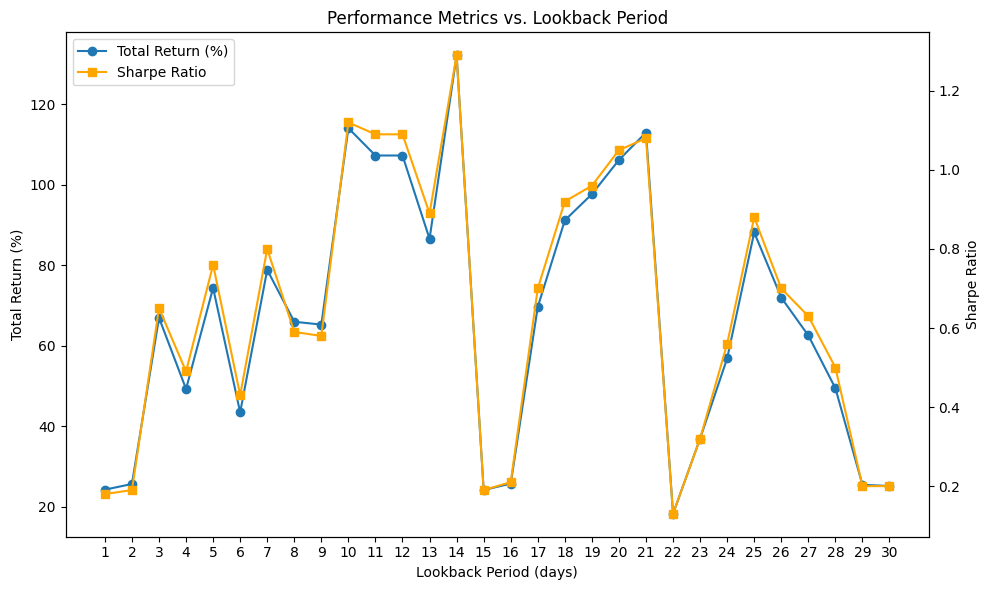

In [5]:
import matplotlib.pyplot as plt

custom_start_date = '2022-12-01'
custom_end_date = '2024-06-14'

range_period = [i for i in range(1, 31, 1)]  # Lookback periods from 7 to 30 days
total_returns = []
Strategy_Sharpes = []

for period in range_period:
    print(f"\n===== Testing Weekly Top 5 Strategy =====")
    _, metrics = top_performers_strategy_simple(
        crypto_data,
        lookback_period=period,    # Look back 7days for performance ranking
        num_top_coins=5,  # Buy top performers based on the current period
        initial_capital=10000, # Starting with $10,000,
        start_date=custom_start_date,
        end_date=custom_end_date,
    )
    total_returns.append(float(metrics['Strategy_Total_Return'][:-2]))  
    Strategy_Sharpes.append(float(metrics['Strategy_Sharpe']))
    
# 3 – Gráfico com eixos Y duplos
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(range_period, total_returns, marker="o", label="Total Return (%)")
ax1.set_xlabel("Lookback Period (days)")
ax1.set_ylabel("Total Return (%)")

ax2 = ax1.twinx()
ax2.plot(range_period, Strategy_Sharpes, marker="s", label="Sharpe Ratio", color="orange")
ax2.set_ylabel("Sharpe Ratio")

# legenda combinada
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

plt.title("Performance Metrics vs. Lookback Period")
plt.xticks(range_period)
plt.tight_layout()
plt.show()

In [6]:
_, metrics = top_performers_strategy_simple(
    crypto_data,
    lookback_period=11,    # Look back 7days for performance ranking
    num_top_coins=5,  # Buy top performers based on the current period
    initial_capital=10000, # Starting with $10,000
    teste=True, # Set to True to print metrics and show plot
    start_date='2021-09-01',
    end_date='2022-09-30',
)

Found 17 cryptocurrencies with sufficient data
Data available range: 2021-01-01 00:00:00 to 2025-04-14 17:00:00
Start date adjusted to 2021-10-01 00:00:00
Common date range: 2021-10-01 00:00:00 to 2022-09-30 00:00:00
Strategy will run from 2021-10-04 to 2022-09-26 with 52 rebalance points
After removing cryptocurrencies with insufficient data: 15 cryptocurrencies
Simulating weekly rebalancing strategy...

Top Performers Strategy Performance Summary:
Total Return: -72.67%
Annualized Return: -73.45%
Annualized Volatility: 68.49%
Sharpe Ratio: -1.13
Maximum Drawdown: 82.62%
BTC Total Return: -60.87%
BTC Annualized Return: -61.68%
BTC Sharpe Ratio: -1.14
BTC Maximum Drawdown: 72.84%
Alpha vs BTC: -11.80%
Unique Cryptocurrencies Held: 15
Avg Cryptos Per Week: 5.0
Total Rebalances: 52


### Estratégia complexa

In [10]:
def top_performers_strategy(
    crypto_data,
    lookback_period=7,          # ainda usado p/ verificar histórico mínimo e alocar datas
    ema_span=7,                 
    num_top_coins=5,
    initial_capital=10_000,
    commission=0.001,
    stop_loss_pct=0.05,
    check_interval_hours=1,
    teste=False,
    start_date=None,
    end_date=None
):
    """
    Estratégia semanal que compra as criptomoedas cujo preço está
    proporcionalmente mais acima da sua EMA de `ema_span` dias,
    com rebalanceamento toda segunda‑feira e stop‑loss horário.

    Parâmetros principais alterados:
    --------------------------------
    ema_span : int
        Janela (dias) usada para calcular a EMA.
    lookback_period : int
        Ainda usado para garantir que cada ativo tenha histórico suficiente
        e para estender o dataframe de preços.
    """

    # ------------------------------------------------------------------
    # 1. Filtra criptos com dados suficientes
    # ------------------------------------------------------------------
    valid_cryptos = {
        sym: df
        for sym, df in crypto_data.items()
        if len(df) > lookback_period * 24 + 10
    }
    # print(f"Found {len(valid_cryptos)} cryptocurrencies with sufficient data")
    if not valid_cryptos:
        print("Error: No cryptocurrencies with sufficient data found.")
        return None, None

    btc_data = valid_cryptos.get("btc")  # pode ser None

    # ------------------------------------------------------------------
    # 2. Determina intervalo de datas comum
    # ------------------------------------------------------------------
    start_dates = [df.index.min() for df in valid_cryptos.values()]
    end_dates   = [df.index.max() for df in valid_cryptos.values()]
    # print(f"Data available range: {min(start_dates)} to {max(end_dates)}")

    common_start = (
        max(start_dates) if start_date is None else pd.to_datetime(start_date)
    )
    common_end   = (
        min(end_dates)   if end_date   is None else pd.to_datetime(end_date)
    )
    if common_start < max(start_dates):
        common_start = max(start_dates)
        # print(f"Start date adjusted to {common_start}")
    if common_end > min(end_dates):
        common_end = min(end_dates)
        # print(f"End date adjusted to {common_end}")
    if common_start >= common_end:
        # print("Error: start date must be before end date")
        return None, None
    # print(f"Common date range: {common_start} to {common_end}")

    # ------------------------------------------------------------------
    # 3. Cria dataframe de preços horário
    # ------------------------------------------------------------------
    all_dates = pd.date_range(
        start=common_start - timedelta(days=lookback_period * 2),
        end=common_end,
        freq=f"{check_interval_hours}H",
    )
    price_df = pd.DataFrame(index=all_dates)
    for sym, df in valid_cryptos.items():
        symbol_prices = pd.DataFrame({"close": df["close"]})
        reindexed = symbol_prices.reindex(all_dates)
        price_df[sym] = reindexed["close"].ffill()
    price_df = price_df.dropna(axis=1, thresh=len(all_dates) * 0.95)
    if price_df.empty:
        # print("Error: No cryptocurrencies with sufficient data after cleaning.")
        return None, None
    price_df = price_df.ffill().bfill()

    # ------------------------------------------------------------------
    # 4. Calcula EMA diária e "EMA‑score" (% acima da EMA)
    # ------------------------------------------------------------------
    daily_price_df = price_df.resample("D").last()
    ema_df = daily_price_df.ewm(span=ema_span, adjust=False).mean()
    ema_score_df = (daily_price_df - ema_df) / ema_df
    ema_score_df = ema_score_df.dropna()

    # ------------------------------------------------------------------
    # 5. Define datas de rebalanceamento (toda segunda)
    # ------------------------------------------------------------------
    start_monday = (common_start + timedelta(days=(7 - common_start.weekday()) % 7)).replace(
        hour=0, minute=0, second=0, microsecond=0
    )
    end_monday = (common_end - timedelta(days=common_end.weekday())).replace(
        hour=0, minute=0, second=0, microsecond=0
    )
    rebalance_dates = pd.date_range(start=start_monday, end=end_monday, freq="W-MON")
    # print(
    #     f"Strategy will run from {start_monday} to {end_monday} with "
    #     f"{len(rebalance_dates)} rebalance points"
    # )

    # ------------------------------------------------------------------
    # 6. Inicializa portfólio
    # ------------------------------------------------------------------
    portfolio_df = pd.DataFrame(index=price_df.loc[start_monday:].index)
    portfolio_df[["Cash", "Crypto_Value", "Total_Value"]] = 0.0
    portfolio_df.loc[:, "Cash"] = initial_capital
    portfolio_df.loc[:, "Total_Value"] = initial_capital

    current_holdings, entry_prices = {}, {}
    current_cash = initial_capital
    trade_history, holdings_history, stop_loss_events = [], {}, []

    # ------------------------------------------------------------------
    # 7. Loop de rebalanceamento semanal
    # ------------------------------------------------------------------
    # print("Simulating strategy with EMA ranking…")
    for i, rebalance_date in enumerate(rebalance_dates):
        next_rebalance = (
            rebalance_dates[i + 1] if i < len(rebalance_dates) - 1 else common_end
        )
        if rebalance_date > common_end:
            break

        # ----- 7.1 Seleciona top performers pelo EMA‑score -----
        week_key = rebalance_date.strftime("%Y-%W")
        closest_date = (
            ema_score_df.index[ema_score_df.index <= rebalance_date][-1]
            if any(ema_score_df.index <= rebalance_date)
            else None
        )
        if closest_date is not None:
            scores = ema_score_df.loc[closest_date]
            top_performers = scores.nlargest(num_top_coins).index.tolist()
            holdings_history[week_key] = top_performers

            # ----- 7.2 Vende posições antigas -----
            for sym, units in list(current_holdings.items()):
                price = price_df.loc[price_df.index[price_df.index <= rebalance_date][-1], sym]
                sale_val = units * price * (1 - commission)
                current_cash += sale_val
                trade_history.append(
                    dict(date=rebalance_date, symbol=sym, action="SELL",
                         units=units, price=price, value=sale_val, reason="REBALANCE")
                )
            current_holdings, entry_prices = {}, {}

            # ----- 7.3 Compra novas posições -----
            alloc = current_cash / num_top_coins if top_performers else 0
            for sym in top_performers:
                price = price_df.loc[price_df.index[price_df.index <= rebalance_date][-1], sym]
                if price > 0:
                    units = alloc * (1 - commission) / price
                    current_holdings[sym] = units
                    entry_prices[sym] = price
                    current_cash -= alloc
                    trade_history.append(
                        dict(date=rebalance_date, symbol=sym, action="BUY",
                             units=units, price=price, value=alloc, reason="REBALANCE")
                    )

        # ----- 7.4 Loop horário entre rebalanceamentos (stop‑loss) -----
        time_range = pd.date_range(
            start=rebalance_date,
            end=next_rebalance - timedelta(hours=check_interval_hours),
            freq=f"{check_interval_hours}H",
        )
        for check_time in time_range:
            if check_time not in price_df.index:
                continue

            # verifica stop‑loss
            to_sell = []
            for sym, units in current_holdings.items():
                price_now = price_df.loc[check_time, sym]
                drop = (entry_prices[sym] - price_now) / entry_prices[sym]
                if drop >= stop_loss_pct:
                    to_sell.append(sym)
                    stop_loss_events.append(
                        dict(date=check_time, symbol=sym, entry_price=entry_prices[sym],
                             exit_price=price_now, drop_pct=drop)
                    )
            for sym in to_sell:
                units = current_holdings.pop(sym)
                price_now = price_df.loc[check_time, sym]
                sale_val = units * price_now * (1 - commission)
                current_cash += sale_val
                entry_prices.pop(sym, None)
                trade_history.append(
                    dict(date=check_time, symbol=sym, action="SELL",
                         units=units, price=price_now, value=sale_val, reason="STOP_LOSS")
                )

            # atualiza valor da carteira
            crypto_val = sum(
                units * price_df.loc[check_time, sym]
                for sym, units in current_holdings.items()
            )
            portfolio_df.loc[check_time, "Cash"] = current_cash
            portfolio_df.loc[check_time, "Crypto_Value"] = crypto_val
            portfolio_df.loc[check_time, "Total_Value"] = current_cash + crypto_val

    portfolio_df = portfolio_df.ffill()

    # ------------------------------------------------------------------
    # 8. Benchmarks (BTC buy‑&‑hold e Equal‑Weight buy‑&‑hold)
    # ------------------------------------------------------------------
    if btc_data is not None and "btc" in price_df.columns:
        start_price = price_df.loc[price_df.index >= start_monday, "btc"].iloc[0]
        btc_units = initial_capital * (1 - commission) / start_price
        portfolio_df["BTC_Value"] = btc_units * price_df.loc[start_monday:, "btc"]

    equal_syms = list(price_df.columns)
    alloc_eq = initial_capital / len(equal_syms)
    portfolio_df["Equal_Weight_Value"] = 0.0
    start_idx = price_df.index[price_df.index >= start_monday][0]
    for sym in equal_syms:
        init_units = alloc_eq * (1 - commission) / price_df.loc[start_idx, sym]
        portfolio_df.loc[start_monday:, "Equal_Weight_Value"] += (
            init_units * price_df.loc[start_monday:, sym]
        )

    # ------------------------------------------------------------------
    # 9. Métricas de performance
    # ------------------------------------------------------------------
    daily = portfolio_df.resample("D").last()
    daily["Strategy_Return"] = daily["Total_Value"] / initial_capital - 1
    daily["Equal_Weight_Return"] = daily["Equal_Weight_Value"] / initial_capital - 1
    if "BTC_Value" in daily:
        daily["BTC_Return"] = daily["BTC_Value"] / initial_capital - 1

    daily["Strategy_Daily_Return"] = daily["Total_Value"].pct_change().fillna(0)
    daily["Equal_Weight_Daily_Return"] = daily["Equal_Weight_Value"].pct_change().fillna(0)
    if "BTC_Value" in daily:
        daily["BTC_Daily_Return"] = daily["BTC_Value"].pct_change().fillna(0)

    daily["Strategy_DD"] = 1 - daily["Total_Value"] / daily["Total_Value"].cummax()
    daily["Equal_Weight_DD"] = 1 - daily["Equal_Weight_Value"] / daily["Equal_Weight_Value"].cummax()
    if "BTC_Value" in daily:
        daily["BTC_DD"] = 1 - daily["BTC_Value"] / daily["BTC_Value"].cummax()

    tot_days = (daily.index[-1] - daily.index[0]).days
    strat_ret = daily["Strategy_Return"].iloc[-4]
    strat_ann = (1 + strat_ret) ** (365 / tot_days) - 1 if tot_days > 0 else np.nan
    strat_vol = daily["Strategy_Daily_Return"].std() * np.sqrt(252)
    strat_sharpe = strat_ann / strat_vol if strat_vol > 0 else 0
    strat_dd = daily["Strategy_DD"].max()

    eq_ret = daily["Equal_Weight_Return"].iloc[-1]
    eq_ann = (1 + eq_ret) ** (365 / tot_days) - 1 if tot_days > 0 else np.nan
    eq_vol = daily["Equal_Weight_Daily_Return"].std() * np.sqrt(252)
    eq_sharpe = eq_ann / eq_vol if eq_vol > 0 else 0
    eq_dd = daily["Equal_Weight_DD"].max()

    if "BTC_Return" in daily:
        btc_ret = daily["BTC_Return"].iloc[-1]
        btc_ann = (1 + btc_ret) ** (365 / tot_days) - 1 if tot_days > 0 else np.nan
        btc_vol = daily["BTC_Daily_Return"].std() * np.sqrt(252)
        btc_sharpe = btc_ann / btc_vol if btc_vol > 0 else 0
        btc_dd = daily["BTC_DD"].max()
        alpha_vs_btc = strat_ret - btc_ret
    else:
        btc_ret = btc_ann = btc_vol = btc_sharpe = btc_dd = alpha_vs_btc = np.nan

    # resumo
    metrics = {
        "Strategy_Total_Return": f"{strat_ret:.2%}",
        "Strategy_Annual_Return": f"{strat_ann:.2%}",
        "Strategy_Volatility": f"{strat_vol:.2%}",
        "Strategy_Sharpe": f"{strat_sharpe:.2f}",
        "Strategy_Max_DD": f"{strat_dd:.2%}",
        "Equal_Weight_Total_Return": f"{eq_ret:.2%}",
        "Equal_Weight_Annual_Return": f"{eq_ann:.2%}",
        "Equal_Weight_Sharpe": f"{eq_sharpe:.2f}",
        "Equal_Weight_Max_DD": f"{eq_dd:.2%}",
        "BTC_Total_Return": f"{btc_ret:.2%}" if not np.isnan(btc_ret) else "N/A",
        "BTC_Annual_Return": f"{btc_ann:.2%}" if not np.isnan(btc_ann) else "N/A",
        "BTC_Sharpe": f"{btc_sharpe:.2f}" if not np.isnan(btc_sharpe) else "N/A",
        "BTC_Max_DD": f"{btc_dd:.2%}" if not np.isnan(btc_dd) else "N/A",
        "Alpha_vs_BTC": f"{alpha_vs_btc:.2%}" if not np.isnan(alpha_vs_btc) else "N/A",
        "Total_Rebalances": len(holdings_history),
        "Total_Stop_Losses": len(stop_loss_events),
    }

    # # ------------------------------------------------------------------
    # # 10. Gráficos (Plotly)
    # # ------------------------------------------------------------------
    if teste:
        fig = make_subplots(
            rows=2,
            cols=1,
            shared_xaxes=True,
            vertical_spacing=0.1,
            subplot_titles=(
                f"Weekly Top {num_top_coins} EMA-Based Strategy (stop-loss {stop_loss_pct:.0%})",
                "Drawdowns",
            ),
            row_heights=[0.7, 0.3],
        )

        fig.add_trace(
            go.Scatter(
                x=daily.index,
                y=daily["Total_Value"].iloc[:-1],
                mode="lines",
                name="EMA Strategy",
                line=dict(width=2),
            ),
            row=1,
            col=1,
        )
        fig.add_trace(
            go.Scatter(
                x=daily.index,
                y=daily["Equal_Weight_Value"].iloc[:-1],
                mode="lines",
                name="Equal‑Weight B&H",
                line=dict(width=2),
            ),
            row=1,
            col=1,
        )
        if "BTC_Value" in daily:
            fig.add_trace(
                go.Scatter(
                    x=daily.index,
                    y=daily["BTC_Value"].iloc[:-1],
                    mode="lines",
                    name="BTC B&H",
                    line=dict(width=2),
                ),
                row=1,
                col=1,
            )
        fig.add_trace(
            go.Scatter(
                x=daily.index,
                y=daily["Strategy_DD"].iloc[:-1] * 100,
                mode="lines",
                name="Strategy DD",
                line=dict(width=2, color="red"),
                fill="tozeroy",
                fillcolor="rgba(255,0,0,0.1)",
            ),
            row=2,
            col=1,
        )
        if "BTC_DD" in daily:
            fig.add_trace(
                go.Scatter(
                    x=daily.index,
                    y=daily["BTC_DD"].iloc[:-1] * 100,
                    mode="lines",
                    name="BTC DD",
                    line=dict(width=2, dash="dash"),
                    fill="tozeroy",
                    fillcolor="rgba(255,165,0,0.1)",
                ),
                row=2,
                col=1,
            )

        # marca eventos de stop‑loss
        if stop_loss_events:
            sl_df = pd.DataFrame(stop_loss_events)
            sl_df["date"] = pd.to_datetime(sl_df["date"])
            fig.add_trace(
                go.Scatter(
                    x=sl_df["date"],
                    y=[
                        daily.loc[daily.index >= d].iloc[0]["Total_Value"]
                        if any(daily.index >= d)
                        else np.nan
                        for d in sl_df["date"]
                    ],
                    mode="markers",
                    name="Stop‑Loss",
                    marker=dict(symbol="x", size=10, color="red"),
                    hoverinfo="text",
                    text=[
                        f"{row.symbol}: drop {row.drop_pct:.2%}"
                        for _, row in sl_df.iterrows()
                    ],
                ),
                row=1,
                col=1,
            )

        fig.update_layout(
            template="plotly_white",
            height=800,
            legend=dict(x=0, y=1, orientation="h"),
            yaxis_title="Portfolio Value ($)",
            yaxis2_title="Drawdown (%)",
        )
        fig.update_yaxes(ticksuffix="%", row=2, col=1)
        fig.show()

    # ------------------------------------------------------------------
    # 11. Retorna dados diários e métricas
    # ------------------------------------------------------------------
    return daily, metrics

In [11]:
_, m = top_performers_strategy(
            crypto_data,
            lookback_period=7,
            ema_span=1,
            num_top_coins=5,
            initial_capital=10_000,
            stop_loss_pct=1,
            check_interval_hours=1,
            start_date=custom_start_date,
            end_date=custom_end_date,
            teste=True,
        )

In [18]:
import numpy as np
import pandas as pd

# ----------------------------------------------------------------------
# 1. Parâmetros de teste
# ----------------------------------------------------------------------
periods = np.arange(1, 31)                 # EMA span (lookback) 1 … 30
stop_losses = np.arange(0.01, 0.51, 0.01)  # Stop‑loss 1% … 50%

n_p, n_sl = len(periods), len(stop_losses)
returns_mat  = np.zeros((n_p, n_sl))       # Total Return (%)
sharpe_mat   = np.zeros((n_p, n_sl))       # Sharpe

# ----------------------------------------------------------------------
# 2. Loop sobre todas as combinações
# ----------------------------------------------------------------------
for i, p in enumerate(periods):
    for j, sl in enumerate(stop_losses):
        _, m = top_performers_strategy(
            crypto_data,
            lookback_period=7,
            ema_span=int(p),
            num_top_coins=5,
            initial_capital=10_000,
            stop_loss_pct=sl,
            check_interval_hours=1,
            start_date=custom_start_date,
            end_date=custom_end_date,
        )
        returns_mat[i, j] = float(m["Strategy_Total_Return"].strip("%"))
        sharpe_mat[i,  j] = float(m["Strategy_Sharpe"])
        print(""*50, end="\r")
        print(f"stop loss: {sl:.2}; {p}/31", end="\r")

# ----------------------------------------------------------------------
# 3. Constrói um Scatter 3‑D
# ----------------------------------------------------------------------
# Achata as matrizes para listas (um ponto por combinação)
x = np.repeat(periods, n_sl)        # EMA span
y = np.tile(stop_losses, n_p)       # stop‑loss
z = returns_mat.flatten()           # Total Return (%)
c = sharpe_mat.flatten()            # cor = Sharpe

fig = go.Figure(
    data=go.Scatter3d(
        x=x, y=y, z=z,
        mode='markers',
        marker=dict(
            size=5,
            color=c,
            colorscale='Viridis',
            colorbar=dict(title='Sharpe'),
            opacity=0.8,
        ),
        text=[f"EMA {px}<br>SL {sy:.0%}<br>Return {rz:.2f}%<br>Sharpe {sc:.2f}"
              for px, sy, rz, sc in zip(x, y, z, c)]
    )
)

fig.update_layout(
    title="EMA span × Stop‑Loss × Total Return<br>(cor = Sharpe)",
    scene=dict(
        xaxis_title="EMA span (dias)",
        yaxis_title="Stop‑loss (%)",
        zaxis_title="Total Return (%)",
        yaxis_tickformat=".0%",
    ),
    template="plotly_white",
    height=800,
)

fig.show()
